# Chapter 8 - Feature Selection

In [2]:
# Basic Libraries

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()

import pandas as pd
import numpy as np

In [3]:
# Specific Libraries

from sklearn.experimental import (
    enable_iterative_imputer,
)
from sklearn import (
    ensemble,
    impute,
    model_selection,    
    preprocessing,
    tree,
)

### The Dataset

In [5]:
# Titanic Dataframe

url = ("https://raw.githubusercontent.com/joanby/python-ml-course/refs/heads/master/datasets/titanic/titanic3.csv")
df = pd.read_csv(url)
orig_df = df

In [6]:
# Begin creating an aggregated DataFrame from 'df'
agg = (
    df.groupby("cabin")     # Group the original DataFrame 'df' by the 'cabin' column
    .agg({col: ["min", "max", "mean", "sum"] for col in df.select_dtypes(include="number").columns}) # Aggregate using min, ... for numeric columns only
    .reset_index()          # Reset the index to flatten the DataFrame structure after grouping
)

agg.columns = [  # Rename columns in 'agg' to clearly indicate the aggregation type (min, max, mean, sum) for each column
    "_".join(c).strip("_")  # Combine multi-level column names into a single string with '_', removing any leading/trailing underscores
    for c in agg.columns.values
]

# Merge the aggregated DataFrame back to the original DataFrame on 'cabin'
agg_df = df.merge(agg, on="cabin")

agg_df.head(3) # Display this new Dataframe

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,...,parch_mean,parch_sum,fare_min,fare_max,fare_mean,fare_sum,body_min,body_max,body_mean,body_sum
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,...,0.5,1,211.3375,211.3375,211.3375,422.675,NaN,NaN,NaN,0.0
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,...,2.0,8,151.5500,151.5500,151.5500,606.200,135.0,135.0,135.0,135.0
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,...,2.0,8,151.5500,151.5500,151.5500,606.200,135.0,135.0,135.0,135.0


In [7]:
agg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 295 entries, 0 to 294
Data columns (total 42 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   pclass         295 non-null    int64  
 1   survived       295 non-null    int64  
 2   name           295 non-null    object 
 3   sex            295 non-null    object 
 4   age            272 non-null    float64
 5   sibsp          295 non-null    int64  
 6   parch          295 non-null    int64  
 7   ticket         295 non-null    object 
 8   fare           295 non-null    float64
 9   cabin          295 non-null    object 
 10  embarked       293 non-null    object 
 11  boat           193 non-null    object 
 12  body           32 non-null     float64
 13  home.dest      258 non-null    object 
 14  pclass_min     295 non-null    int64  
 15  pclass_max     295 non-null    int64  
 16  pclass_mean    295 non-null    float64
 17  pclass_sum     295 non-null    int64  
 18  survived_m

In [8]:
from sklearn import model_selection 
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer  
from sklearn.preprocessing import StandardScaler 

def tweak_titanic(df):
    # Drop unnecessary columns and convert categorical columns to dummy variables
    df = df.drop(
        columns=[
            "name",          # Drop passenger name column
            "ticket",        # Drop ticket column
            "home.dest",     # Drop home destination column
            "boat",          # Drop boat information column
            "body",          # Drop body number column
            "cabin",         # Drop cabin information column
        ]
    ).pipe(pd.get_dummies, drop_first=True)  # Convert categorical variables to dummy variables, dropping the first category
    return df                                # Return the cleaned and transformed DataFrame

def get_train_test_X_y(
    df, y_col, size=0.3, std_cols=None
):
    y = df[y_col]               # Extract the target variable
    X = df.drop(columns=y_col)  # Drop target variable from feature set
    
    X_train, X_test, y_train, y_test = model_selection.train_test_split(   # Split data into training and test sets
        X, y, test_size=size, random_state=42
    )
    cols = X.columns  # Get list of feature columns
    
    num_cols = [      # List of numeric columns to impute for missing values
        "pclass",
        "age",
        "sibsp",
        "parch",
        "fare",
    ]
    fi = IterativeImputer()                       # Initialize IterativeImputer for imputing missing values
    fitted = fi.fit_transform(X_train[num_cols])  # Fit and transform imputer on training numeric columns
    
    # Update training DataFrame with imputed values for numeric columns
    X_train = X_train.assign(**{c: fitted[:, i] for i, c in enumerate(num_cols)})
    test_fit = fi.transform(X_test[num_cols])  # Transform test data using the same imputer
    
    # Update test DataFrame with imputed values for numeric columns
    X_test = X_test.assign(**{c: test_fit[:, i] for i, c in enumerate(num_cols)})
    
    # Standardize specified columns if any are provided
    if std_cols:
        std = StandardScaler()  # Initialize StandardScaler
        fitted = std.fit_transform(X_train[std_cols])  # Fit and transform scaler on training standardization columns
        # Update training DataFrame with standardized values
        X_train = X_train.assign(**{c: fitted[:, i] for i, c in enumerate(std_cols)})
        test_fit = std.transform(X_test[std_cols])     # Transform test data using the same scaler
        # Update test DataFrame with standardized values
        X_test = X_test.assign(**{c: test_fit[:, i] for i, c in enumerate(std_cols)})

    # Return training and test sets for features and target
    return X_train, X_test, y_train, y_test

# Apply the functions to preprocess the Titanic dataset
ti_df = tweak_titanic(orig_df)                 # Clean and transform the original DataFrame
std_cols = "pclass,age,sibsp,fare".split(",")  # Specify columns to standardize

# Split the preprocessed data into training and test sets
X_train, X_test, y_train, y_test = get_train_test_X_y(
    ti_df, "survived", std_cols=std_cols
)

# Concatenate training and test sets for features and target variables for further use
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

In [9]:
orig_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     1309 non-null   int64  
 1   survived   1309 non-null   int64  
 2   name       1309 non-null   object 
 3   sex        1309 non-null   object 
 4   age        1046 non-null   float64
 5   sibsp      1309 non-null   int64  
 6   parch      1309 non-null   int64  
 7   ticket     1309 non-null   object 
 8   fare       1308 non-null   float64
 9   cabin      295 non-null    object 
 10  embarked   1307 non-null   object 
 11  boat       486 non-null    object 
 12  body       121 non-null    float64
 13  home.dest  745 non-null    object 
dtypes: float64(3), int64(4), object(7)
memory usage: 143.3+ KB


### Collinear Columns

We can use the previously defined correlated_columns function or run the following code to find columns that have a cor‐relation coefficient of .95 or above:

In [12]:
limit = 0.95                     # Set correlation threshold above which columns will be considered highly correlated

numeric_df = agg_df.select_dtypes(include=[float, int])  # Select only numeric columns from 'agg_df'

corr = numeric_df.corr()         # Calculate the correlation matrix for numeric columns only

mask = np.triu(                  # Create an upper triangle mask to ignore lower triangle correlations, including the diagonal
    np.ones(corr.shape), k=1
).astype(bool)                   # Convert to Boolean to use in filtering

corr_no_diag = corr.where(mask)  # Apply mask to the correlation matrix, setting lower triangle and diagonal to NaN

coll = [                         # Initialize a list of columns to keep those with correlations above the threshold
    c
    for c in corr_no_diag.columns
    if any(abs(corr_no_diag[c]) > limit)  # Check if any correlation in column 'c' exceeds the limit (close to 1)
]

coll                             # Output the list of columns with 10 high correlations

['pclass_min',
 'pclass_max',
 'pclass_mean',
 'sibsp_mean',
 'parch_mean',
 'fare_mean',
 'body_min',
 'body_max',
 'body_mean',
 'body_sum']

In [13]:
# 10 high correlations
agg_df[coll].head()

,pclass_min,pclass_max,pclass_mean,sibsp_mean,parch_mean,fare_mean,body_min,body_max,body_mean,body_sum
0,1,1,1.0,0.0,0.5,211.3375,NaN,NaN,NaN,0.0
1,1,1,1.0,1.0,2.0,151.5500,135.0,135.0,135.0,135.0
2,1,1,1.0,1.0,2.0,151.5500,135.0,135.0,135.0,135.0
3,1,1,1.0,1.0,2.0,151.5500,135.0,135.0,135.0,135.0
4,1,1,1.0,1.0,2.0,151.5500,135.0,135.0,135.0,135.0


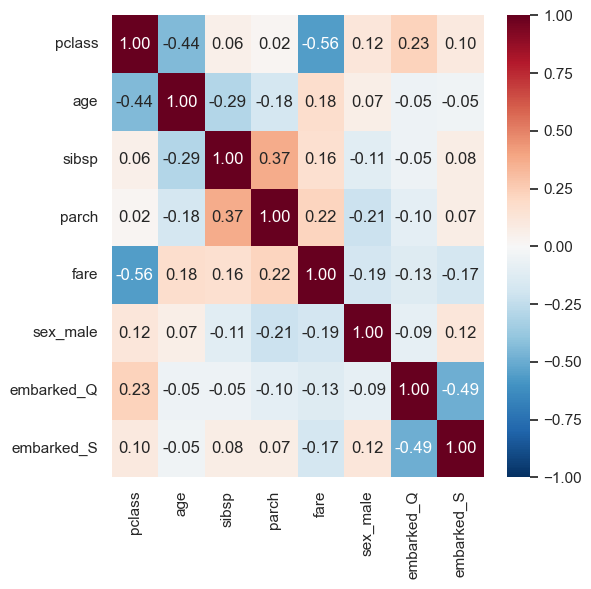

In [14]:
from seaborn import heatmap             # Import the heatmap function from Seaborn for correlation matrix visualization

fig, ax = plt.subplots(figsize=(6, 6))  # Create a figure and axis with dimensions 6x6 inches
ax = heatmap(                           # Generate a heatmap to display the correlation matrix of features in X
    X.corr(),                           # Compute the correlation matrix for the DataFrame X
    fmt=".2f",                          # Format the annotation text to 2 decimal places
    annot=True,                         # Annotate each cell in the heatmap with its correlation value
    ax=ax,                              # Use the specified axis for the plot
    cmap="RdBu_r",                      # Set the color palette to 'RdBu_r' (red to blue, reversed)
    vmin=-1,                            # Set the minimum value of the color scale to -1 (strong negative correlation)
    vmax=1,                             # Set the maximum value of the color scale to 1 (strong positive correlation)
)

In [15]:
from sklearn.ensemble import RandomForestClassifier  

cols_to_remove = [   # Define a list of columns to exclude from the feature set
    "pclass",
    "sibsp",
    "parch",
    "embarked_Q",
]

rf3 = RandomForestClassifier(random_state=42)  # Initialize RandomForestClassifier with a fixed random state for reproducibility

rf3.fit(             # Train rf3 on X_train, excluding columns listed in cols_to_remove
    X_train[
        [
            c
            for c in X_train.columns
            if c not in cols_to_remove         # Filter columns by excluding those in cols_to_remove
        ]
    ],
    y_train,         # Use y_train as the target variable
)

rf3.score(           # Evaluate rf3’s performance on X_test with excluded columns
    X_test[
        [
            c
            for c in X_train.columns
            if c not in cols_to_remove         # Ensure the same columns are excluded from X_test as in X_train
        ]
    ],
    y_test,          # Use y_test as the true labels for scoring
)

rf4 = RandomForestClassifier(random_state=42)  # Initialize another RandomForestClassifier without column exclusions
rf4.fit(X_train, y_train)                      # Train rf4 on the full set of X_train columns
rf4.score(X_test, y_test)                      # Evaluate rf4’s performance on the full X_test columns

0.7837150127226463

### Lasso Regression

* Lasso Regression is a linear regression model that includes a penalty term to constrain or shrink the regression coefficients.

* Unlike standard linear regression, Lasso incorporates an L1 regularization term, which adds the absolute value of the magnitude of coefficients to the loss function.

* This penalty discourages the model from overfitting by reducing the size of some coefficients and even forcing some coefficients to be zero.

If you use lasso regression, you can set an alpha parameter that acts as a regularization parameter. As you increase the value, it gives less weight to features that are less important. Here we use the LassoLarsCV model to iterate over various values of alpha and track the feature coefficients:

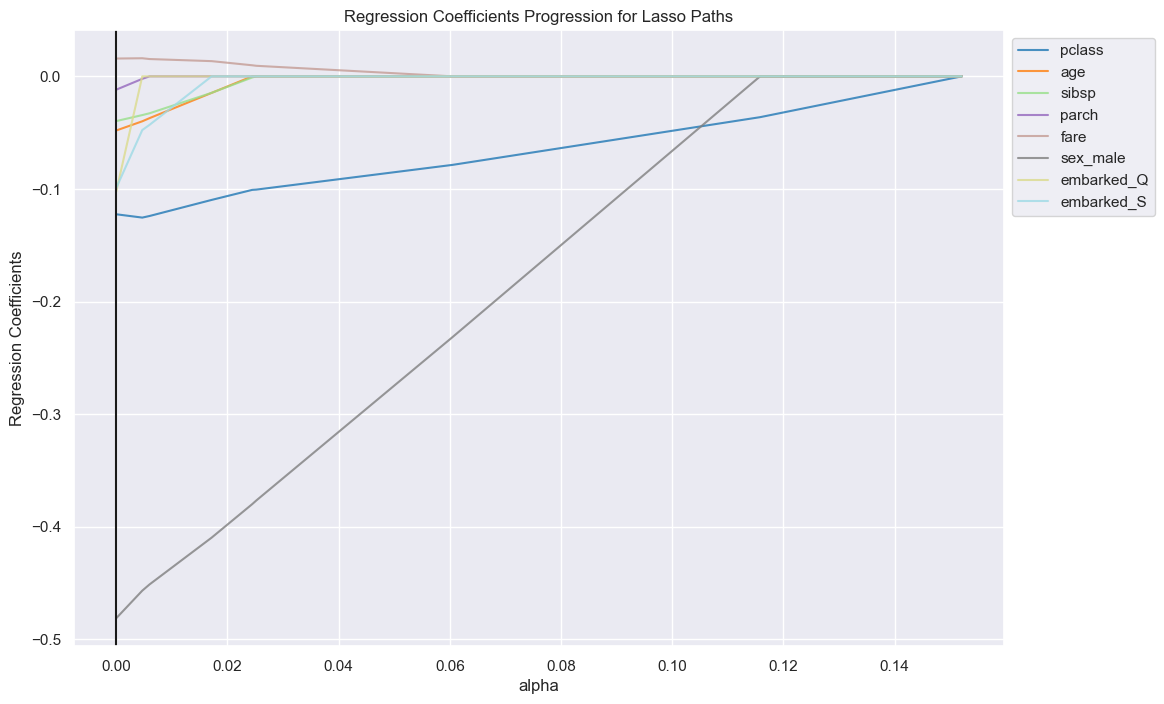

In [19]:
from sklearn import linear_model

# Initialize LassoLarsCV model with cross-validation
model = linear_model.LassoLarsCV(
    cv=10,               # cv=10: Use 10-fold cross-validation
    max_n_alphas=10      # max_n_alphas=10: Set the maximum number of alpha values to consider
).fit(X_train, y_train)  # Fit the model on the training data

# Create a figure and axis for plotting
fig, ax = plt.subplots(figsize=(12, 8))

# Initialize a color map iterator for distinct colors for each feature
cm = iter(
    plt.get_cmap("tab20")(             # Use the 'tab20' colormap
        np.linspace(0, 1, X.shape[1])  # Create evenly spaced colors for each feature
    )
)

# Iterate over each feature to plot its coefficient path
for i in range(X.shape[1]):         # Loop through each feature index
    c = next(cm)                    # Get the next color from the color map
    ax.plot(
        model.alphas_,              # Alpha values from the model
        model.coef_path_.T[:, i],   # Coefficient path for each alpha for the feature
        c=c,                        # Set line color
        alpha=0.8,                  # Set line transparency
        label=X.columns[i],         # Label as feature name for the legend
    )

# Plot a vertical line at the chosen alpha (model.alpha_) from cross-validation
ax.axvline(
    model.alpha_,      # Alpha value selected by cross-validation
    linestyle="-",     # Solid line style
    c="k",             # Black color for the line
    label="alphaCV",   # Label for the legend
)

# Set y-axis label
plt.ylabel("Regression Coefficients")

# Add legend with feature names positioned outside the plot
ax.legend(X.columns, bbox_to_anchor=(1, 1))

# Set x-axis label
plt.xlabel("alpha")

# Set title for the plot
plt.title("Regression Coefficients Progression for Lasso Paths");

This plot shows the progression of regression coefficients for various features in a Lasso model as the regularization parameter, alpha, changes.

#### 1. Lasso Regularization and Alpha:
- The Lasso (Least Absolute Shrinkage and Selection Operator) model introduces a regularization term to the regression, 
which penalizes the absolute size of the coefficients.
- The regularization parameter alpha controls this penalty. A higher alpha results in stronger regularization, shrinking coefficients toward zero.
- This can lead to some coefficients becoming exactly zero, effectively "dropping" the associated feature from the model.

#### 2. Interpreting the Coefficient Paths:
- The x-axis represents different values of alpha, starting from a low value on the left (minimal regularization) 
to higher values on the right (more regularization).
- The y-axis shows the value of each regression coefficient for the features (like 'pclass', 'age', 'sibsp', etc.) in the model.
- Each colored line represents the coefficient path for a different feature as alpha increases.

#### 3. Key Observations:
- `sex_male` (gray line): This feature has the most significant negative coefficient, and as alpha increases, its absolute coefficient value decreases.
However, it remains a dominant feature in the model.
- `pclass` (blue line): This feature's coefficient stays mostly stable but decreases slightly as regularization increases, 
suggesting it is important but somewhat less sensitive to alpha.
- Other Features: Many features (e.g., `fare`, `parch`) have coefficients near zero or become zero with increased alpha, 
meaning they are less relevant or are excluded from the model under strong regularization.

#### 4. Chosen Alpha:
- The black vertical line marks the value of alpha selected through cross-validation (labeled 'alphaCV'). 
This is the optimal balance between fitting the data well and keeping the model simple by avoiding overfitting.
- At this chosen alpha, some coefficients are close to zero, meaning those features are less influential in the model's predictions.

**In summary**, this plot helps illustrate which features are most relevant to the model as regularization increases, 
with stronger regularization leading to smaller or zero coefficients for less important features.
The selected alpha (vertical line) indicates the point at which the model optimally balances complexity and predictive accuracy.

### Recursive Feature Elimination

Recursive feature elimination will remove the weakest features, then fit a model.

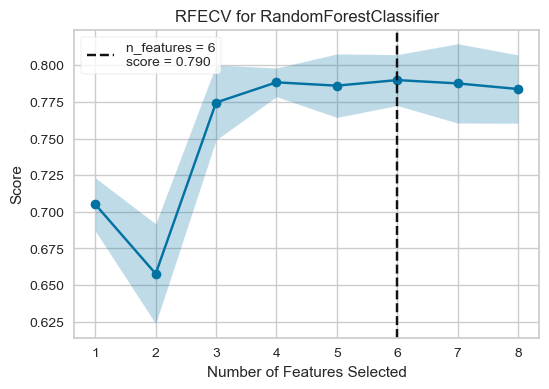

In [22]:
from yellowbrick.features import RFECV  # Import RFECV (Recursive Feature Elimination with Cross-Validation)


fig, ax = plt.subplots(figsize=(6, 4))  # Create a figure and axis with dimensions 6x4 inches for visualization
rfe = RFECV(                            # Initialize the RFECV visualizer
    ensemble.RandomForestClassifier(    # Use Random Forest as the estimator for feature selection
        n_estimators=100                # Set the number of trees in the forest to 100
    ),
    cv=5,                               # Use 5-fold cross-validation for evaluating feature importance
)
rfe.fit(X, y)                           # Fit the RFE model on features (X) and target (y) to rank and select features
rfe.rfe_estimator_.ranking_             # Retrieve the ranking of features; lower numbers indicate more important features
rfe.rfe_estimator_.n_features_          # Get the number of selected features deemed most important by the RFE
rfe.rfe_estimator_.support_             # Obtain a boolean array indicating which features are selected
rfe.poof();                             # Render the plot to visualize the optimal number of features and their importance

This RFECV (Recursive Feature Elimination with Cross-Validation) graph provides insight into the optimal number of features to retain for a RandomForestClassifier to achieve the best predictive performance.

The vertical dashed line indicates the optimal number of features selected by RFECV. In this case, it is 4 features, as noted in the legend. This is where the score is maximized before it plateaus or begins to drop.

The highest score is achieved when 4 features are included, with a score of approximately 0.794.

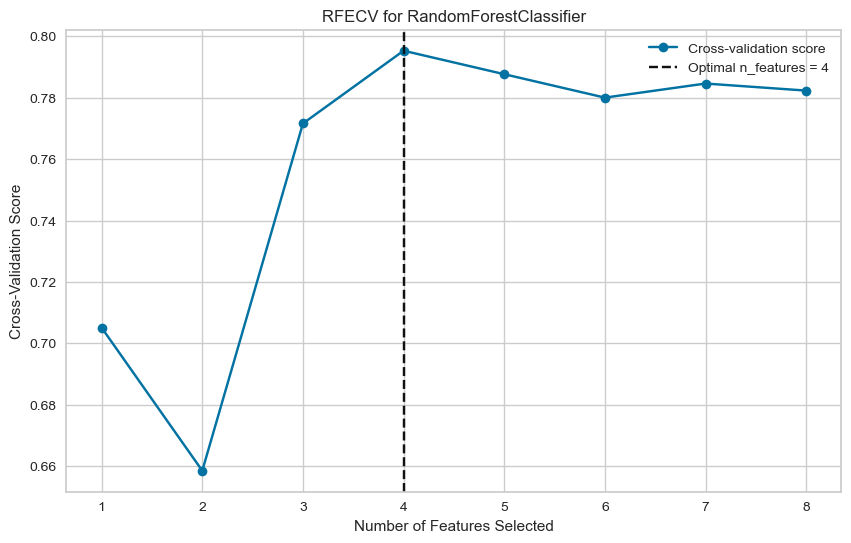

Optimal number of features: 4
Best cross-validation score: 0.7953


In [24]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold


# Initialize RFECV with a RandomForestClassifier
rfe = RFECV(
    estimator=RandomForestClassifier(n_estimators=100, random_state=42),
    step=1,                     # Choose the number of features to remove at each iteration
    cv=StratifiedKFold(5),      # Stratified k-fold cross-validation
    scoring="accuracy"          # Metric for evaluation
)

# Fit the RFECV model
rfe.fit(X, y)

# Extract cross-validation scores
scores = rfe.cv_results_['mean_test_score']

# Plot the cross-validation scores for each number of features
plt.figure(figsize=(10, 6))
plt.plot(
    range(1, len(scores) + 1),
    scores,
    marker="o",
    linestyle="-",
    color="b",
    label="Cross-validation score"
)
plt.xlabel("Number of Features Selected")
plt.ylabel("Cross-Validation Score")
plt.title("RFECV for RandomForestClassifier")
plt.axvline(rfe.n_features_, linestyle="--", color="k", label=f"Optimal n_features = {rfe.n_features_}")
plt.legend()
plt.show()

# Print the optimal number of features
print("Optimal number of features:", rfe.n_features_)
print("Best cross-validation score:", round(max(scores),4))

In [25]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

# Initialize the model
model = RandomForestClassifier(n_estimators=100)

# Set up RFE to select 4 features
rfe = RFE(estimator=model, n_features_to_select=4)

# Fit RFE on the dataset
rfe.fit(X, y)

# Get the selected feature names
selected_features = X.columns[rfe.support_]
selected_features

Index(['pclass', 'age', 'fare', 'sex_male'], dtype='object')

### Mutual Information

Sklearn provides nonparametric tests that will use k-nearest neighbor to determine the mutual information between features and the target. Mutual information quantifies the amount of information gained by observing another variable. The value is zero or more. If the value is zero, then there is no relation between them. This number is not bounded and represents the number of bits shared between the feature and the target:

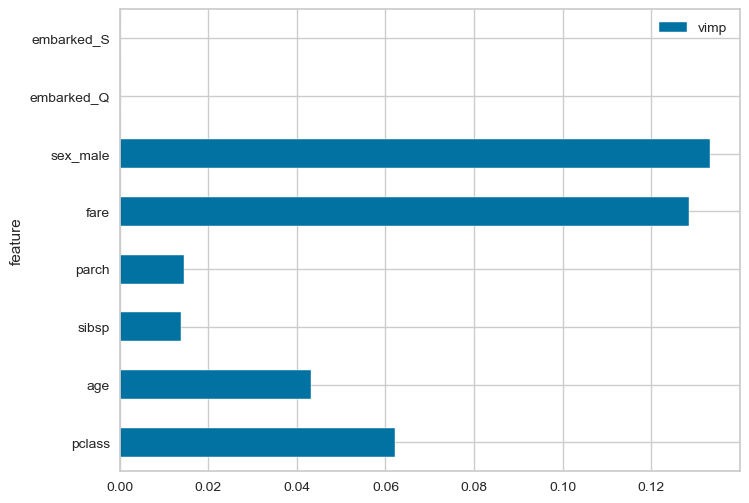

In [27]:
from sklearn import feature_selection

# Calculate the mutual information between each feature and the target variable
mic = feature_selection.mutual_info_classif( # `mutual_info_classif` finds dependency between each feature and target
    X, y                                     # 'X' is the feature matrix, 'y' is the target variable
)

# Create a figure and axis for plotting
fig, ax = plt.subplots(figsize=(8, 6))       # Set the plot size to 8x6 inches

# Prepare the data for plotting as a horizontal bar chart
(
    pd.DataFrame(                            # Create a DataFrame to organize feature importance values
        {"feature": X.columns, "vimp": mic}  # 'feature' column for feature names, 'vimp' column for importance values
    )
    .set_index("feature")                    # Set 'feature' column as index for easy labeling in the plot
    .plot.barh(ax=ax)                        # Plot a horizontal bar chart on the specified axis 'ax'
);

### Principal Component Analysis

Another option for feature selection is to run principal component analysis. Once you have the main principal components, examine the features that contribute to them the most. These are features that have more variance. Note that this is an unsupervised algorithm and doesn’t take y into account.

### Feature Importance

Most tree models provide access to a `.feature_importances_` attribute following training. A higher importance typically means that there is higher error when the feature is removed from the model.